In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from sklearn.preprocessing import LabelEncoder
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
mercedes_df=pd.read_csv('Mercedes.csv')
output=mercedes_df['y']
mercedes_df.drop(columns=['y'],inplace=True)


In [15]:
cols_to_drop=[]
for col in mercedes_df.columns:
    if len(np.unique(mercedes_df[col]))==1 or len(np.unique(mercedes_df[col]))==mercedes_df.shape[0]:
        cols_to_drop.append(col)
         
cols_to_drop
mercedes_df.drop(columns=cols_to_drop,inplace=True)
mercedes_df.shape

(4209, 364)

In [16]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(mercedes_df,output,test_size=0.2,random_state=42)
#le=LabelEncoder()


class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [17]:
le=LabelEncoderExt()

cat_cols=[col for col in X_train.columns if X_train[col].dtype=='object']
for col in cat_cols:
    le.fit(X_train[col])
    X_train[col]=le.transform(X_train[col])
    X_test[col]=le.transform(X_test[col])
    


C:\Users\TEMP\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\TEMP\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


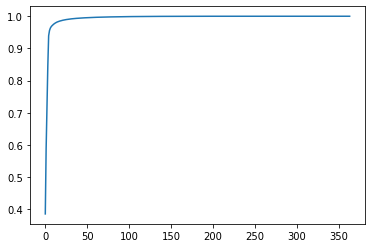

In [18]:
from sklearn.decomposition import PCA

pca=PCA()
X_train_pca_df=pd.DataFrame(pca.fit_transform(X_train))
plt.plot(np.cumsum(pca.explained_variance_ratio_))


In [19]:
pca_1=PCA(n_components=50)

X_train_pca1_df=pd.DataFrame(pca_1.fit_transform(X_train),columns=list(range(0,50)))

X_test_pca1_df=pd.DataFrame(pca_1.transform(X_test))


In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_pca = pd.DataFrame()
vif_pca["VIF Factor_PCA"] = [variance_inflation_factor(X_train_pca1_df.values, i) for i in range(X_train_pca1_df.shape[1])]
vif_pca['Column Name']=X_train_pca1_df.columns


In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

vif['Column Name']=X_train.columns


C:\Users\TEMP\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\TEMP\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error

lin_reg_1=LinearRegression()
lin_reg_1.fit(X_train_pca1_df,y_train)

y_linreg_pred=lin_reg_1.predict(X_test_pca1_df)

r2_score(y_true=y_test,y_pred=y_linreg_pred)
print('Train Score:----',lin_reg_1.score(X_train_pca1_df,y_train))
print('Test Score:----',lin_reg_1.score(X_test_pca1_df,y_test))

mean_squared_error(y_test,y_linreg_pred)

Train Score:---- 0.5206684305292373
Test Score:---- 0.5381978323548828


71.87947952164659

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error

random_forest=RandomForestRegressor()
random_forest.fit(X_train_pca1_df,y_train)

y_randomforest_pred=random_forest.predict(X_test_pca1_df)

r2=r2_score(y_test,y_randomforest_pred)
print('r2:',r2)

In [ ]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

hyp_dic={'max_depth':[3,5,8,9],
         'min_samples_split':[3,6,9,10],
         'min_samples_leaf':[4,5,6]}
gridcv=GridSearchCV(estimator=random_forest,param_grid=hyp_dic,cv=5)
gridcv.fit(X_train_pca1_df,y_train)

gridcv.best_params_


In [ ]:
gridcv.best_score_
#for random forest hyperparameter tuning

In [30]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_boost=GradientBoostingRegressor()
gradient_boost.fit(X_train_pca1_df,y_train)

y_gradientboost_pred=gradient_boost.predict(X_test_pca1_df)

r2=r2_score(y_test,y_gradientboost_pred)
print('r2:',r2)



r2: 0.5218890000794201


In [38]:
from sklearn.model_selection import GridSearchCV


hyp_dic1={'learning_rate':[0.01,0.05,0.1,1,0.5],
          'n_estimators':[100],
          'max_depth':[3,4,5],
          'min_samples_split':[4,5,6],
          'min_samples_leaf':[4,5,6],
          'subsample':[0.6,0.7,0.8,1],
          'max_features':['sqrt'],
          'random_state':[10]}

gridcv1=GridSearchCV(gradient_boost,param_grid=hyp_dic1,cv=5)
gridcv1.fit(X_train_pca1_df,y_train)

gridcv1.best_score_



0.5084755664083451